In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import modules
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [3]:
# List of biome numbers
biomes = [1,2,3,4,5,6,7,8]

In [88]:
# Read in dataset
biomeDictLAI = pd.read_pickle('G:/cassidy/MODISLANDSAT_py37/biomeDictLAI.pkl')
# https://drive.google.com/file/d/1ivoVZchQNN_0mcrVvaZr1_F7lA6yDXBg/view?usp=share_link

In [90]:
# List of regressors
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
# Response
response = 'LAI'

# Subsampling calibration and validation data to create training and testing datasets for each biome
for i in biomes:
    dfcal = biomeDictLAI[i]['calDF'].sample(10000)
    dfval = biomeDictLAI[i]['valDF'].sample(100)

    biomeDictLAI[i]['X_train'] = dfcal[regressors]
    biomeDictLAI[i]['y_train'] = dfcal[response]

    biomeDictLAI[i]['X_test'] = dfval[regressors]
    biomeDictLAI[i]['y_test'] = dfval[response]

## Random Forest Regression

In [147]:
# Creating and fitting a Random Forest Regressor for each biome type (100 trees per forest)
for i in biomes:
    biomeDictLAI[i]['rf'] = RandomForestRegressor(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)
    biomeDictLAI[i]['rf'] = biomeDictLAI[i]['rf'].fit(biomeDictLAI[i]['X_train'], biomeDictLAI[i]['y_train'])

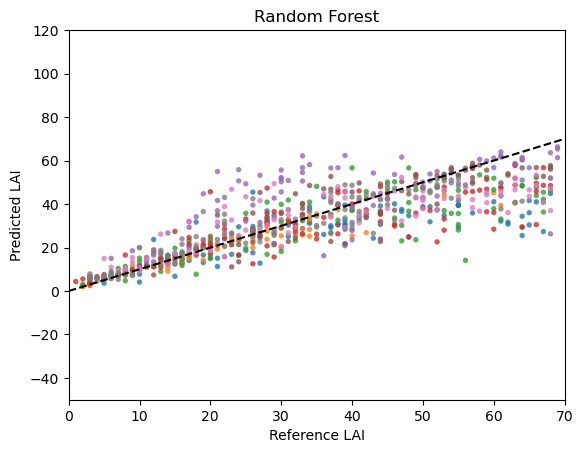

In [99]:
# Plotting the Quantile Regression Forest with error bars
axes = []
for i in biomes:
    biomeDictLAI[i]['y_hat'] = biomeDictLAI[i]['rf'].predict(biomeDictLAI[i]['X_test'])
    axes.append(plt.scatter(biomeDictLAI[i]['y_test'], biomeDictLAI[i]['y_hat'], s=15, alpha=0.8, edgecolors='none', label=str(i)))
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title('Random Forest')
plt.xlim([0, 70])
plt.ylim([-50, 120])
# plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5), title='Biome')
plt.show()

## Scikit-garden

To use Scikit-Garden:

  Package       |  Version          |  Notes
----------------------------------------------------------------
  python        |  3.7              |  
  numpy         |  1.21  (default)  |
  matplotlib    |  3.5   (default)  |
  pandas        |  1.2   (default)  |
  scikit-learn  |  0.22  (default)  |
  scikit-garden |  0.1.3 (default)  |  install with conda-forge
  jupyterlab    |  3.6   (default)  |  install with pip

In [92]:
# Import scikit-garden module
from skgarden import RandomForestQuantileRegressor

In [93]:
# Creating a Random Forest Quantile Regressor for each biome type (100 trees per forest)
for i in biomes:
    biomeDictLAI[i]['rfqr'] = RandomForestQuantileRegressor(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)

In [94]:
print(biomeDictLAI[1]['rfqr'])

RandomForestQuantileRegressor(bootstrap=True, criterion='mse', max_depth=None,
                              max_features=5, max_leaf_nodes=10000,
                              min_samples_leaf=10, min_samples_split=2,
                              min_weight_fraction_leaf=0.0, n_estimators=100,
                              n_jobs=-1, oob_score=False, random_state=0,
                              verbose=0, warm_start=False)


In [151]:
# Fitting and predicting a Random Forest Quantile Regressor for each biome type with 95% prediction confidence interval
for i in biomes:
    biomeDictLAI[i]['rfqr'].set_params(max_features=biomeDictLAI[i]['X_train'].shape[1] // 3)
    biomeDictLAI[i]['rfqr'] = biomeDictLAI[i]['rfqr'].fit(biomeDictLAI[i]['X_train'], biomeDictLAI[i]['y_train'])
    biomeDictLAI[i]['upper'] = biomeDictLAI[i]['rfqr'].predict(biomeDictLAI[i]['X_test'], quantile=98.5)
    biomeDictLAI[i]['lower'] = biomeDictLAI[i]['rfqr'].predict(biomeDictLAI[i]['X_test'], quantile=2.5)
    biomeDictLAI[i]['mid'] = biomeDictLAI[i]['rfqr'].predict(biomeDictLAI[i]['X_test'], quantile=50)

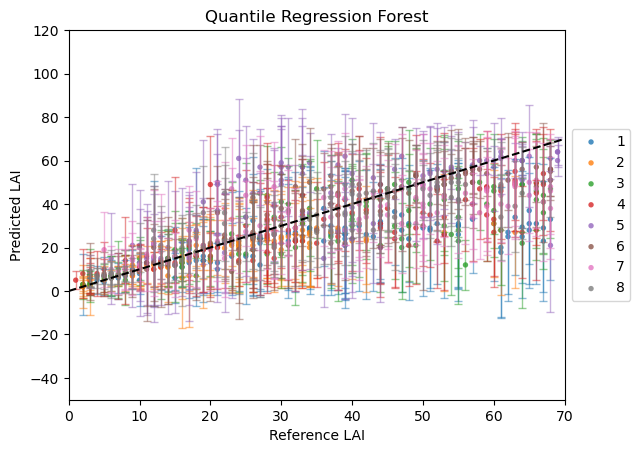

In [109]:
# Plotting the Quantile Regression Forest with error bars
axes = []
for i in biomes:
    plt.errorbar(biomeDictLAI[i]['y_test'], biomeDictLAI[i]['mid'], yerr=np.divide(np.subtract(biomeDictLAI[i]['upper'], biomeDictLAI[i]['lower']), 2), alpha=0.5, ls='None', lw=1, capsize=3)
    axes.append(plt.scatter(biomeDictLAI[i]['y_test'], biomeDictLAI[i]['mid'], s=15, alpha=0.8, edgecolors='none', label=str(i)))
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title('Quantile Regression Forest')
plt.xlim([0, 70])
plt.ylim([-50, 120])
plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Comparing Random Forest and Quantile Forest

In [125]:
i=1
ests = biomeDictLAI[i]['rfqr'].estimators_
ests2 = biomeDictLAI[i]['rf'].estimators_
print(ests[0].get_n_leaves())
print(ests2[0].get_n_leaves())

469
487


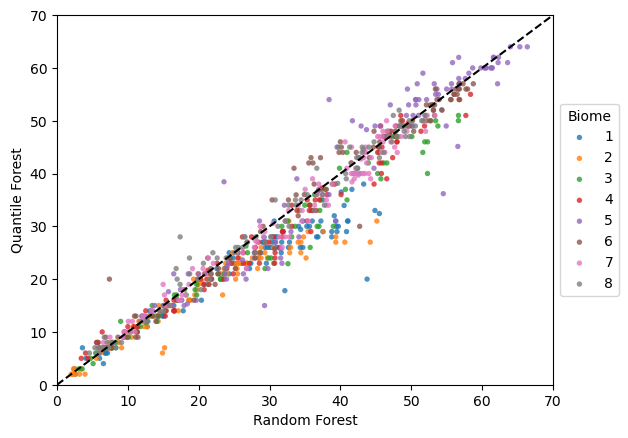

In [101]:
axes=[]
for i in biomes:
    axes.append(plt.scatter(biomeDictLAI[i]['y_hat'], biomeDictLAI[i]['mid'], s=15, alpha=0.8, edgecolors='none', label=str(i)))
    
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Random Forest")
plt.ylabel("Quantile Forest")
# plt.title('Random Forest')
plt.xlim([0, 70])
plt.ylim([0, 70])
plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5), title='Biome')
plt.show()

## TensorFlow

In [113]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [114]:
np.shape(np.array(biomeDictLAI[i]['X_train']))

(10000, 5)

In [115]:
for i in biomes:
    normalizer = layers.Normalization(input_shape=[5,], axis=None)
    normalizer.adapt(np.array(biomeDictLAI[i]['X_train']))
    
    biomeDictLAI[i]['model'] = tf.keras.Sequential([
        normalizer,
        layers.Dense(50, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(1)])

In [116]:
for i in biomes:
    biomeDictLAI[i]['model'].compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])

In [117]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.99:                 
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

In [118]:
for i in biomes:
    callbacks = myCallback()
    biomeDictLAI[i]['history'] = biomeDictLAI[i]['model'].fit(biomeDictLAI[i]['X_train'].to_numpy(), biomeDictLAI[i]['y_train'].to_numpy(), epochs=100, validation_split=0.2, verbose=0, callbacks=[callbacks])
    biomeDictLAI[i]['y_nn'] = biomeDictLAI[i]['model'].predict(biomeDictLAI[i]['X_test'])

4/4 [==============================] - 0s 2ms/step


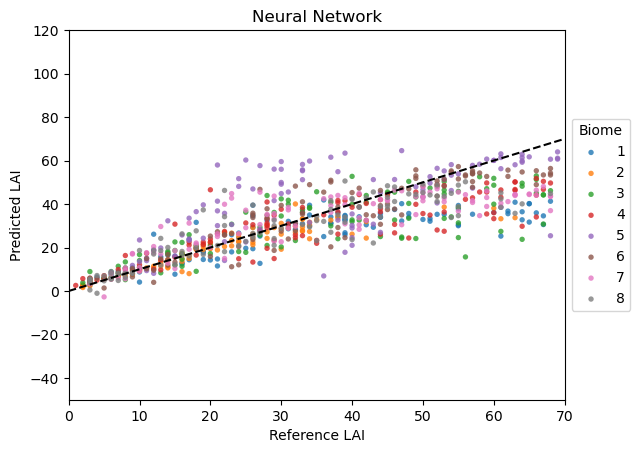

In [119]:
axes = []
for i in biomes:
    axes.append(plt.scatter(biomeDictLAI[i]['y_test'], biomeDictLAI[i]['y_nn'], s=15, alpha=0.8, edgecolors='none', label=str(i)))
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title('Neural Network')
plt.xlim([0, 70])
plt.ylim([-50, 120])
plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5), title='Biome')
plt.show()

In [120]:
biomeDictLAI[2]['model'].summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_17 (Normaliza  (None, 5)                3         
 tion)                                                           
                                                                 
 dense_51 (Dense)            (None, 50)                300       
                                                                 
 dense_52 (Dense)            (None, 50)                2550      
                                                                 
 dense_53 (Dense)            (None, 1)                 51        
                                                                 
Total params: 2,904
Trainable params: 2,901
Non-trainable params: 3
_________________________________________________________________


In [121]:
i = 5
biomeDictLAI[i]['model'].evaluate(biomeDictLAI[i]['X_test'],  biomeDictLAI[i]['y_test'], verbose=2)

4/4 - 0s - loss: 216.9129 - mean_squared_error: 216.9129 - 182ms/epoch - 45ms/step


[216.91287231445312, 216.91287231445312]

In [ ]:
temp = []
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, figsize=(10,6))
for i in biomes:
    axes[0,1].errorbar(biomeDictLAI[i]['y_test'], biomeDictLAI[i]['mid'], yerr=np.divide(np.subtract(biomeDictLAI[i]['upper'], biomeDictLAI[i]['lower']), 2), alpha=0.5, ls='None', lw=1, capsize=3)
    axes[0,1].scatter(biomeDictLAI[i]['y_test'], biomeDictLAI[i]['mid'], s=15, alpha=0.8, edgecolors='none', label=str(i))
    axes[0,0].scatter(biomeDictLAI[i]['y_test'], biomeDictLAI[i]['y_hat'], s=15, alpha=0.8, edgecolors='none', label=str(i))
    temp.append(axes[1,0].scatter(biomeDictLAI[i]['y_test'], biomeDictLAI[i]['y_nn'], s=15, alpha=0.8, edgecolors='none', label=str(i)))

for axs in axes:
    for ax in axs:
        ax.plot([0, 70], [0, 70], 'k--')
        ax.set_xlim([0, 70])
        ax.set_ylim([-50, 120])
    
axes[0,0].set_ylabel("Predicted LAI")
axes[1,0].set_ylabel("Predicted LAI")
axes[1,0].set_xlabel("Reference LAI")
axes[1,1].set_xlabel("Reference LAI")
axes[0,1].set_title('Quantile Regression Forest')
axes[0,0].set_title('Random Forest')
axes[1,0].set_title('Neural Network')
axes[1,1].set_title('TensorFlow Probability')
fig.tight_layout()
fig.legend(handles=temp, loc='center left', bbox_to_anchor=(1, 0.5), title='Biome')

## TensorFlow Probability

In [172]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [178]:
def neg_loglik(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [173]:
for i in biomes:
    normalizer = layers.Normalization(input_shape=[5,], axis=None)
    normalizer.adapt(np.array(biomeDictLAI[i]['X_train']))
    
    biomeDictLAI[i]['model'] = tf.keras.Sequential([
        normalizer,
        layers.Dense(50, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(tfpl.IndependentNormal.params_size(1)),
        tfpl.IndependentNormal(event_shape=1)])

In [179]:
for i in biomes:
    biomeDictLAI[i]['model'].compile(optimizer='adam',
                  loss=neg_loglik,
                  metrics=['mean_squared_error'])

In [180]:
for i in biomes:
    callbacks = myCallback()
    biomeDictLAI[i]['model'].fit(biomeDictLAI[i]['X_train'].to_numpy(), biomeDictLAI[i]['y_train'].to_numpy(), epochs=100, validation_split=0.2, verbose=0, callbacks=[callbacks])
    biomeDictLAI[i]['y_nn'] = biomeDictLAI[i]['model'].predict(biomeDictLAI[i]['X_test'])

4/4 [==============================] - 0s 3ms/step


In [205]:
i=1
y_mean = biomeDictLAI[i]['model'](biomeDictLAI[i]['X_test']).mean()
y_sd = biomeDictLAI[i]['model'](biomeDictLAI[i]['X_test']).stddev()

y_hat_lower = y_hat - 2 * y_sd
y_hat_upper = y_hat + 2 * y_sd

## Create and upload trees

In [129]:
from sklearn.tree import export_text